In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def sigmoid(x):                                        
   return 1 / (1 + np.exp(-x))

In [2]:
path="C:/Users/dexte/github/RoboSkin/Code/Models/labeller/"
lin_path="/its/home/drs25/Documents/GitHub/RoboSkin/Code/Models/labeller"

#load datasets
X1=np.load(path+"X_data_push.npy")
y1=np.load(path+"y_data_push.npy")

X2=np.load(path+"X_data_edge.npy")
y2=np.load(path+"y_data_edge.npy")

X3=np.load(path+"X_data_slip.npy")
y3=np.load(path+"y_data_slip.npy")

#merge datasets
X=np.concatenate([X1,X2,X3])
SIZE=X.shape[1]
X=X.reshape((X.shape[0],133*2*SIZE))/100
y=np.concatenate([y1,y2,y3])/10

X, data_test, y, labels_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(X.shape,y.shape)
print(data_test.shape,labels_test.shape)

(1032, 2660) (1032, 5)
(259, 2660) (259, 5)


In [21]:

# Define the size of the input (n) and output (m) layers
n_inputs = 133*2*SIZE
m_outputs = len(y[0])


# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Define the neural network model
class SimpleNeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size,layers=[100,10],drop_out_prob=0.2):
        super(SimpleNeuralNetwork, self).__init__()
        self.fc=[nn.Linear(input_size, layers[0])]
        self.fc.append(nn.ReLU())
        self.fc.append(nn.Dropout(p=drop_out_prob))
        for i in range(1,len(layers)): #create layers 
                self.fc.append(nn.Linear(layers[i-1], layers[i]))
                self.fc.append(nn.ReLU())
                self.fc.append(nn.Dropout(p=drop_out_prob))
        self.fc.append(nn.Linear(layers[-1], output_size))
        self.fc_layers = nn.Sequential(*self.fc)
    def forward(self, x):
        x=self.fc_layers(x)
        return x

# Create the neural network
model = SimpleNeuralNetwork(n_inputs, m_outputs)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)



Epoch [1/1500], Loss: 0.0003 Accuracy 0.8970588235294118
Epoch [1001/1500], Loss: 0.0004 Accuracy 0.9052287581699346


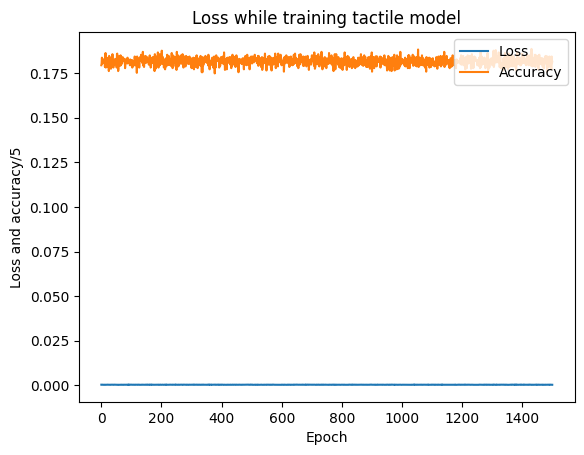

In [28]:
# Training loop
def get_acc(predictions,should_be=[]):
    predictions*=10 #normalize
    pred_array=np.zeros_like(predictions)
    inds=np.argmax(predictions[:,0:2],axis=1) #convert at threshold
    inds2=np.argmax(predictions[:,2:-1],axis=1) #convert at threshold
    for i in range(len(pred_array)):
        pred_array[i][inds[i]]=1
        pred_array[i][2+inds2[i]]=1
    correct=0
    for j,pred in enumerate(pred_array): #loopthrough predictions
        inds=np.where(pred==1) #
        if len(should_be)>0: #validation task
            sb=should_be[j]*10
            sb=np.where(sb==1)
            if len(sb[0])==len(inds[0]):
                c=0
                for i in range(len(sb[0])):
                    if sb[0][i]==inds[0][i]: c+=1
                if c==len(sb[0]): correct+=1
    return correct/len(should_be)

def train(model,num_epochs=1500):
    loss_ar=[]
    accuracies=[]
    for epoch in range(num_epochs):
        # Forward pass
        y_pred = model(X_tensor)

        # Compute the loss
        loss = criterion(y_pred, y_tensor)

        # Zero gradients, backward pass, and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_ar.append(loss.item())
        #predict
        predictions = model(torch.tensor(X, dtype=torch.float32))
        accuracies.append(get_acc(predictions.detach().numpy(),should_be=y))
        # Print the current loss to monitor training progress
        if epoch%1000==0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}","Accuracy",accuracies[-1])
    return np.array(loss_ar),np.array(accuracies)

plt.title("Loss while training tactile model")
plt.ylabel("Loss and accuracy/5")
plt.xlabel("Epoch")
a,b=train(model)
plt.plot(a,label="Loss")
plt.plot(b/5,label="Accuracy")
plt.legend(loc="upper right")
plt.show()

In [30]:
# After training, you can use the trained model for predictions on new data.
# For example, if you have new input data 'X_new', you can do:
with torch.no_grad():
     model.eval()
     predictions = model(torch.tensor(data_test, dtype=torch.float32))


def predict(predictions,should_be=[]):
    predictions*=10 #normalize
    pred_array=np.zeros_like(predictions)
    inds=np.argmax(predictions[:,0:2],axis=1) #convert at threshold
    inds2=np.argmax(predictions[:,2:-1],axis=1) #convert at threshold
    for i in range(len(pred_array)):
        pred_array[i][inds[i]]=1
        pred_array[i][2+inds2[i]]=1
    names=["edge", "surface", "soft", "hard", "slippery"]
    array=[]
    correct=0
    for j,pred in enumerate(pred_array): #loopthrough predictions
        inds=np.where(pred==1) #
        ar=[]
        if len(should_be)>0: #validation task
            sb=should_be[j]*10
            sb=np.where(sb==1)
            if len(sb[0])==len(inds[0]):
                c=0
                for i in range(len(sb[0])):
                    if sb[0][i]==inds[0][i]: c+=1
                if c==len(sb[0]): correct+=1
        for i in inds[0]:
            ar.append(names[i])
        array.append(ar)
    if correct!=0: print("Percentage correct:",(correct/len(should_be))*100,"%")
    return array

p=predict(predictions,should_be=labels_test)
p[0:10]  

Percentage correct: 100.0 %


[['edge', 'hard'],
 ['edge', 'hard'],
 ['surface', 'hard'],
 ['edge', 'hard'],
 ['surface', 'hard'],
 ['edge', 'hard'],
 ['edge', 'hard'],
 ['edge', 'hard'],
 ['surface', 'hard'],
 ['surface', 'hard']]

# Experiments

### With and without slippage

Epoch [1/1500], Loss: 0.0456 Accuracy 0.3382352941176471
Epoch [1001/1500], Loss: 0.0001 Accuracy 0.9722222222222222
Epoch [1/1500], Loss: 0.0203 Accuracy 0.1781045751633987
Epoch [1001/1500], Loss: 0.0010 Accuracy 0.5392156862745098
Epoch [1/1500], Loss: 0.0459 Accuracy 0.3709150326797386
Epoch [1001/1500], Loss: 0.0002 Accuracy 0.9738562091503268
Epoch [1/1500], Loss: 0.0288 Accuracy 0.6928104575163399
Epoch [1001/1500], Loss: 0.0004 Accuracy 0.8725490196078431
Epoch [1/1500], Loss: 0.0162 Accuracy 0.5506535947712419
Epoch [1001/1500], Loss: 0.0001 Accuracy 0.9738562091503268
Epoch [1/1500], Loss: 0.0420 Accuracy 0.2761437908496732
Epoch [1001/1500], Loss: 0.0002 Accuracy 0.923202614379085


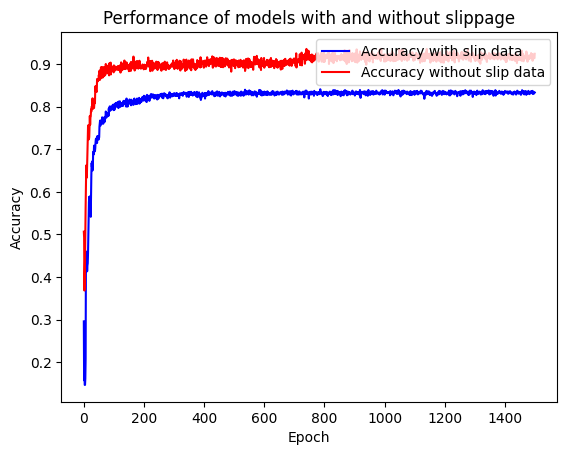

In [29]:
average_l=np.zeros((1500,))
average_a=np.zeros((1500,))
TRIALS=3
for i in range(TRIALS):
    # Create the neural network
    model = SimpleNeuralNetwork(n_inputs, m_outputs)

    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    l,a=train(model)
    average_l+=np.array(l)
    average_a+=np.array(a)
average_l=average_l/TRIALS
average_a=average_a/(TRIALS) #average by 10 and then divide by 5 for scaling

#plt.plot(average_l,'--',c="b",label="Loss with slip data")
plt.plot(average_a,c="b",label="Accuracy with slip data")

#without slippage
#merge datasets
X=np.concatenate([X1,X2])
SIZE=X.shape[1]
X=X.reshape((X.shape[0],133*2*SIZE))/100
y=np.concatenate([y1,y2])/10

X, data_test, y, labels_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

average_l=np.zeros((1500,))
average_a=np.zeros((1500,))
TRIALS=3
for i in range(TRIALS):
    # Create the neural network
    model = SimpleNeuralNetwork(n_inputs, m_outputs)

    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    l,a=train(model)
    average_l+=np.array(l)
    average_a+=np.array(a)
average_l=average_l/TRIALS
average_a=average_a/(TRIALS) #average by 10 and then divide by 5 for scaling



plt.title("Performance of models with and without slippage over 100 trials")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.plot(average_l,c="r",label="Loss without slip data")
plt.plot(average_a,c="r",label="Accuracy without slip data")
plt.legend(loc="lower right")
plt.show()